# <div style="text-align: center; color: cyan">Plot and TensorBoard</div>

## <div style="text-align: center; color: lime">Setup</div>

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"

## <div style="text-align: center; color: lime">Imports</div>

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt

import torch
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import ImageFolder
from torchvision import transforms

import keras
from keras import layers
from keras.applications import MobileNetV2

import kagglehub

import datetime

## <div style="text-align: center; color: lime">Load the data</div>

In [3]:
path = kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification")

data_path = Path(path) / "tom_and_jerry/tom_and_jerry"

trs = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

all_data = ImageFolder(data_path, transform=trs)

g1 = torch.Generator().manual_seed(20)
train_data, val_data, test_data = random_split(all_data, [0.7, 0.2, 0.1], g1)

train_loader = DataLoader(train_data, batch_size=12, shuffle=True)
val_loader = DataLoader(val_data, batch_size=12, shuffle=False)
test_loader = DataLoader(test_data, batch_size=12, shuffle=False)


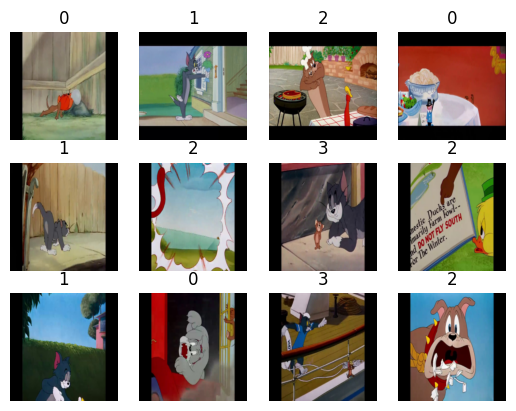

In [4]:
fig, axes = plt.subplots(3, 4)

axes_ravel = axes.ravel()

for images, labels in train_loader:
    for i, (image, label) in enumerate(zip(images, labels)):
        axes_ravel[i].imshow(transforms.ToPILImage()(image))
        axes_ravel[i].set_axis_off()
        axes_ravel[i].set_title(f"{label}")
    break

## <div style="text-align: center; color: lime">Transfer Learning</div>

In [5]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = keras.Sequential(
    [
        layers.Input(shape=(3, 224, 224)),
        layers.Permute((2, 3, 1)),
        base_model,
        layers.Flatten(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute (Permute)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       250,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,508,868 (9.57 MB)

 Trainable params: 250,884 (980.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [6]:
history = model.fit(train_loader, epochs=5, validation_data=val_loader)

Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.4196 - loss: 8.8365 - val_accuracy: 0.5401 - val_loss: 7.0196
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step - accuracy: 0.5419 - loss: 7.0818 - val_accuracy: 0.5246 - val_loss: 7.2620
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - accuracy: 0.5614 - loss: 6.8139 - val_accuracy: 0.5730 - val_loss: 6.5371
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - accuracy: 0.5922 - loss: 6.3468 - val_accuracy: 0.6077 - val_loss: 6.1032
Epoch 5/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 49s 152ms/step - accuracy: 0.6034 - loss: 6.2222 - val_accuracy: 0.5894 - val_loss: 6.4547


In [7]:
loss, accuracy = model.evaluate(test_loader)

print("loss:", loss)
print("accuracy:", accuracy)

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.6362 - loss: 5.7030
loss: 5.703044891357422
accuracy: 0.6361974477767944


## <div style="text-align: center; color: lime">Plot</div>

In [8]:
print(history)

In [12]:
print(history.params)

{'verbose': 'auto', 'epochs': 5, 'steps': 320}


In [9]:
print(history.history)

{'accuracy': [0.41955670714378357, 0.5418513417243958, 0.5614081025123596, 0.5921773314476013, 0.6033898591995239], 'loss': [8.836509704589844, 7.081783294677734, 6.813899517059326, 6.346843242645264, 6.222221374511719], 'val_accuracy': [0.540145993232727, 0.5246350169181824, 0.5729926824569702, 0.6076642274856567, 0.5894160866737366], 'val_loss': [7.019584655761719, 7.262048721313477, 6.537136554718018, 6.103211879730225, 6.454712390899658]}


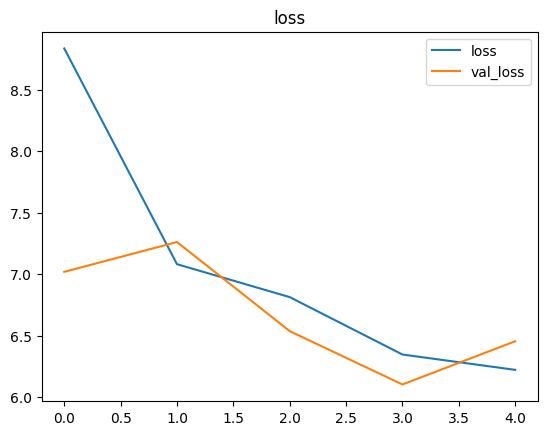

In [13]:
plt.figure()
plt.title("loss")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])

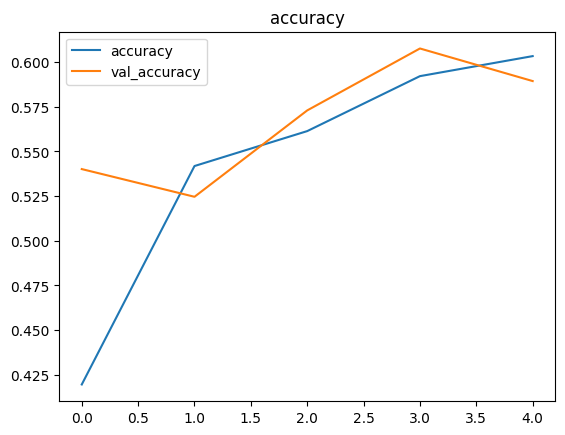

In [14]:
plt.figure()
plt.title("accuracy")
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

## <div style="text-align: center; color: lime">TensorBoard</div>

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = keras.Sequential(
    [
        layers.Input(shape=(3, 224, 224)),
        layers.Permute((2, 3, 1)),
        base_model,
        layers.Flatten(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


In [ ]:
history = model.fit(
    train_loader,
    epochs=5,
    validation_data=val_loader,
    callbacks=[tensorboard_callback],
)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

<p style="text-align: center; font-family: "Trebuchet MS", sans-serif; color: #888; font-size: 0.9em; margin-top: 2em; border-top: 1px solid #ccc; padding-top: 0.5em;">
    @LiterallyTheOne — PhD Candidate in Artificial Intelligence
</p>

<div style="text-align: center">
<a style="margin: 1em" href="https://literallytheone.github.io">https://literallytheone.github.io</a>
</div>
